In [1]:
import cv2
import math
import time
import json
import glob
import seaborn as sn
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
def plot_confusion_matrix(confusion_matrix,index,columns,x_label,y_label):
    df_cm = pd.DataFrame(confusion_matrix, index, columns)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')
    #sns.set(font_scale=1.4)
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='YlGnBu', fmt='g') # font size
    accuracy = sum(sum(np.eye(confusion_matrix.shape[0], dtype=int)*confusion_matrix))/sum(sum(confusion_matrix))
    plt.title("Accuracy:{}% ,Total:{}\nComparison Matrix".format(round(accuracy*100,1),sum(sum(confusion_matrix))))
    plt.xlabel('{}'.format(x_label) , fontsize=18)
    plt.ylabel('{}'.format(y_label), fontsize=18)
    plt.show()
        
def get_precision_recallrate(array,raw):
    for index,class_ in enumerate(raw):
        class_predict_num = sum(array[:,index])
        class_true_num = sum(array[index])
        precision = array[index,index]/class_predict_num
        recall = array[index][index]/class_true_num
        print('Class {} Precision:{}% Recall_rate:{}%'.format(class_,round(precision*100,1),round(recall*100,1)))

def confusion_matrix_balance(confusion_matrix):
    max_sum = max([sum(row) for row in confusion_matrix])
    balance = confusion_matrix.copy()
    for index,row in enumerate(confusion_matrix):
        row = (row*max_sum/sum(row)).astype('int64')
        balance[index] = row
    return balance

def combine_class_in_matrix(confusion_matrix,index_list,max_column):
    combine_matrix = confusion_matrix.copy()
    for column in index_list:
        for ele in column[:-1]:
            combine_matrix[column[-1]] = confusion_matrix[column[-1]]+confusion_matrix[ele]
    for index,row in enumerate(combine_matrix):
        for column in index_list:
            for ele in column[:-1]:
                row[column[-1]] = row[column[-1]]+row[ele]
                combine_matrix[index] = row
    remain_list = [i for i in range(max_column+1)]
    for column in index_list:
        remain_list.remove(column[-1])
    for i in remain_list:
        for index in range(max_column+1):
            combine_matrix[i][index]=0
            combine_matrix[index][i]=0
    index = 0
    for column in combine_matrix:
        if(column.any()==0):
            combine_matrix = np.delete(combine_matrix, index, axis=0)
            combine_matrix = np.delete(combine_matrix, index, axis=1)
        else:
            index+=1
    return combine_matrix



In [3]:
Match_result_csv_path = '../csv_file/PBL_match_result_all_cej_bone_fold1.csv'
Match_result_csv = pd.read_csv(Match_result_csv_path)
Match_result_dropna = Match_result_csv.dropna()
Match_result_dropna.to_csv('../csv_file/PBL_result_all_fold1_dropna.csv')

print(len(Match_result_dropna))

9434


In [4]:
Match_result_csv.head()

,Unnamed: 0,image_name,tooth_side,stage,PBL_predict_tooth,PBL_value,PBL_stage,tooth_path,CEJ_points,Bone_level_points
0,0,NN_190619_104716_EA3E9,9M,1.0,9_L,12.255,1,NN_190619_104716_EA3E9_0.PNG,1,1
1,1,NN_190619_104716_EA3E9,9D,1.0,9_R,9.233,1,NN_190619_104716_EA3E9_0.PNG,1,1
2,2,NN_190619_104716_EA3E9,10M,3.0,10_L,27.999,2,NN_190619_104716_EA3E9_1.PNG,1,1
3,3,NN_190619_104716_EA3E9,10D,3.0,10_R,70.792,3,NN_190619_104716_EA3E9_1.PNG,1,1
4,4,NN_190619_104720_EA3E7,7D,1.0,7_L,32.519,2,NN_190619_104720_EA3E7_1.PNG,1,1


In [5]:
# Match_result_csv_path = '../csv_file/HV_stage_majority_20210201.csv'
# Match_result_csv = pd.read_csv(Match_result_csv_path)

# Match_result_csv_name = list(set(list(Match_result_csv['tooth_path'])))
# print(len(Match_result_csv_name))

In [6]:
# 2523顆

In [7]:
# Match_result_dropna = Match_result_csv.fillna(-999)

In [8]:
Match_result_dropna_tabel = Match_result_csv["image_name"]
print(len(Match_result_dropna_tabel))
Match_result_dropna_list  = list(set(Match_result_dropna_tabel))
print(len(Match_result_dropna_list))

10055
2523


In [9]:
#get training data name list 
img_path_list = glob.glob('/root/notebooks/jeff/0801_Unet_test/0801/train_0801/image/*.PNG')
print(len(img_path_list))
img_name_list = [img_path.split('/')[-1][:-4] for img_path in img_path_list]
print(img_name_list[0])
print(len(img_name_list))

Ground_truth_stage = []
PBL_predict_stage = []

for index, row in Match_result_dropna.iterrows():
    if row['image_name'] not in img_name_list:
        Ground_truth_stage.append(row['stage'])
        PBL_predict_stage.append(row['PBL_stage'])
print(len(Ground_truth_stage)==len(PBL_predict_stage))
print(len(Ground_truth_stage))

148
NN_140908_151608_A53213
148
True
8222


In [10]:
# Ground_truth_stage = Match_result_dropna['stage']
# PBL_predict_stage = Match_result_dropna['PBL_stage']

In [11]:
Ground_truth_stage_list = list(Ground_truth_stage) 
PBL_predict_stage_list = list(PBL_predict_stage) 

In [12]:
print(set(Ground_truth_stage_list))
print(set(PBL_predict_stage_list))

{0.0, 1.0, 2.0, 3.0}
{'No_match', '3', '1', '-999', '2', '0'}


In [13]:
Ground_truth_stage_list_clean = []
PBL_predict_stage_list_clean = []

count0 = 0
count1 = 0
count2 = 0
count3 = 0
count999 = 0

for G,P in zip(Ground_truth_stage_list,PBL_predict_stage_list):
    if G == -99:
        Ground_truth_stage_list_clean.append(-999)
    else:
        Ground_truth_stage_list_clean.append(G)
        
    if P == -999:
        PBL_predict_stage_list_clean.append(-999)
    elif P == 'No_match':
        PBL_predict_stage_list_clean.append(-888)
    else:
        PBL_predict_stage_list_clean.append(int(P))
    
    if P!=-999 and P!='No_match':
        if G==0 and int(P)==0:
            count0+=1
        elif G==1 and int(P)==1:
            count1+=1
        elif G==2 and int(P)==2:
            count2+=1
        elif G==3 and int(P)==3:
            count3+=1     
print(count0)
print(count1)
print(count2)
print(count3)

797
2400
811
329


# Show all the set

In [14]:
print(set(Ground_truth_stage_list_clean))
print(set(PBL_predict_stage_list_clean))

{0.0, 1.0, 2.0, 3.0}
{0, 1, 2, 3, -888, -999}


In [15]:
Ground_truth_stage_list_clean.append(-999)
PBL_predict_stage_list_clean.append(-999)

# Using the All classes(5 classes) to confusin matrix

In [16]:
from sklearn.metrics import confusion_matrix
array_5_classes  = confusion_matrix(Ground_truth_stage_list_clean, PBL_predict_stage_list_clean)

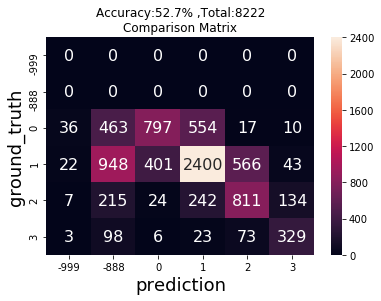

Class -999 Precision:0.0% Recall_rate:nan%
Class -888 Precision:0.0% Recall_rate:nan%
Class 0 Precision:64.9% Recall_rate:42.5%
Class 1 Precision:74.6% Recall_rate:54.8%
Class 2 Precision:55.3% Recall_rate:56.6%
Class 3 Precision:63.8% Recall_rate:61.8%


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [17]:
raw_5 = ['-999','-888','0','1','2','3']
columns_5 = ['-999','-888','0','1','2','3']
array_5_classes_0 = array_5_classes.copy()
array_5_classes_0[0][0] = 0
plot_confusion_matrix(array_5_classes_0,raw_5,columns_5,'prediction','ground_truth')
get_precision_recallrate(array_5_classes_0,raw_5)

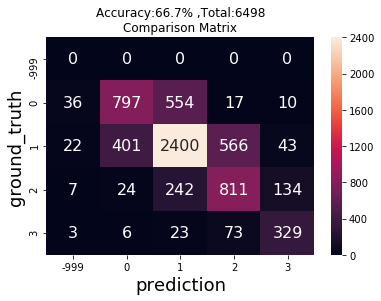

Class -999 Precision:0.0% Recall_rate:nan%
Class 0 Precision:64.9% Recall_rate:56.4%
Class 1 Precision:74.6% Recall_rate:69.9%
Class 2 Precision:55.3% Recall_rate:66.6%
Class 3 Precision:63.8% Recall_rate:75.8%


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [18]:
index_list  = [[0],[2],[3],[4],[5]]
max_column = 5
combine_matrix = combine_class_in_matrix(array_5_classes,index_list,max_column)
# print(array_5_classes.shape)
# print(combine_matrix.shape)


combine_matrix_0 = combine_matrix.copy()
combine_matrix_0[0][0]=0
raw_5 = ['-999','0','1','2','3']
columns_5 = ['-999','0','1','2','3']
plot_confusion_matrix(combine_matrix_0,raw_5,columns_5,'prediction','ground_truth')
get_precision_recallrate(combine_matrix_0,raw_5)

In [19]:
combine_matrix_for_3_class = combine_matrix.copy()

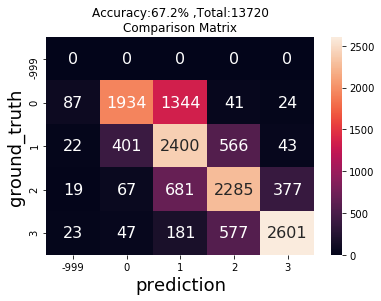

Class -999 Precision:0.0% Recall_rate:nan%
Class 0 Precision:79.0% Recall_rate:56.4%
Class 1 Precision:52.1% Recall_rate:69.9%
Class 2 Precision:65.9% Recall_rate:66.6%
Class 3 Precision:85.4% Recall_rate:75.9%


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [20]:
raw_only_stage = ['-999','0','1','2','3']
columns_only_stage = ['-999','0','1','2','3']

balance = confusion_matrix_balance(combine_matrix)
balance[0][0]=0
plot_confusion_matrix(balance,raw_only_stage,columns_only_stage,'prediction','ground_truth')
get_precision_recallrate(balance,raw_only_stage)

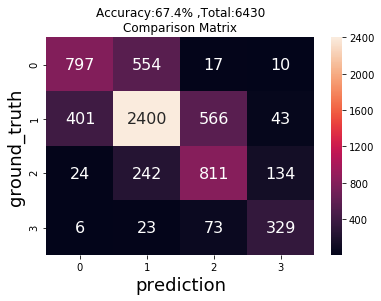

Class 0 Precision:64.9% Recall_rate:57.8%
Class 1 Precision:74.6% Recall_rate:70.4%
Class 2 Precision:55.3% Recall_rate:67.0%
Class 3 Precision:63.8% Recall_rate:76.3%


In [21]:
index_list  = [[2],[3],[4],[5]]
max_column = 5
combine_matrix = combine_class_in_matrix(array_5_classes,index_list,max_column)
#print(combine_matrix)

raw_only_stage = ['0','1','2','3']
columns_only_stage = ['0','1','2','3']
plot_confusion_matrix(combine_matrix,raw_only_stage,columns_only_stage,'prediction','ground_truth')
get_precision_recallrate(combine_matrix,raw_only_stage)

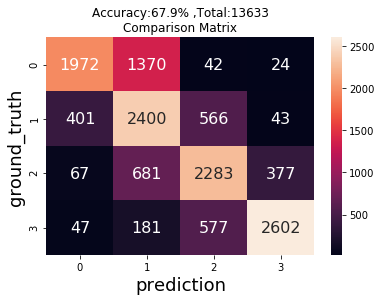

Class 0 Precision:79.3% Recall_rate:57.9%
Class 1 Precision:51.8% Recall_rate:70.4%
Class 2 Precision:65.8% Recall_rate:67.0%
Class 3 Precision:85.4% Recall_rate:76.4%


In [22]:
index_list  = [[2],[3],[4],[5]]
max_column = 5
combine_matrix = combine_class_in_matrix(array_5_classes,index_list,max_column)
#print(combine_matrix)

raw_only_stage = ['0','1','2','3']
columns_only_stage = ['0','1','2','3']

balance = confusion_matrix_balance(combine_matrix)
plot_confusion_matrix(balance,raw_only_stage,columns_only_stage,'prediction','ground_truth')
get_precision_recallrate(balance,raw_only_stage)

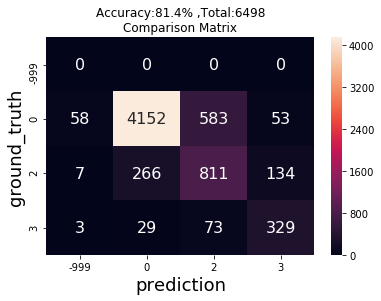

Class -999 Precision:0.0% Recall_rate:nan%
Class 0 Precision:93.4% Recall_rate:85.7%
Class 2 Precision:55.3% Recall_rate:66.6%
Class 3 Precision:63.8% Recall_rate:75.8%


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [23]:
index_list  = [[0],[1,2],[3],[4]]
max_column = 4
combine_matrix_3_class = combine_class_in_matrix(combine_matrix_for_3_class.copy(),index_list,max_column)
#print(combine_matrix)
combine_matrix_3_class_0 = combine_matrix_3_class.copy()
binary = combine_matrix_3_class_0.copy()
combine_matrix_3_class_0[0,0]=0
raw_only_stage = ['-999','0','2','3']
columns_only_stage = ['-999','0','2','3']
plot_confusion_matrix(combine_matrix_3_class_0,raw_only_stage,columns_only_stage,'prediction','ground_truth')
get_precision_recallrate(combine_matrix_3_class_0,raw_only_stage)

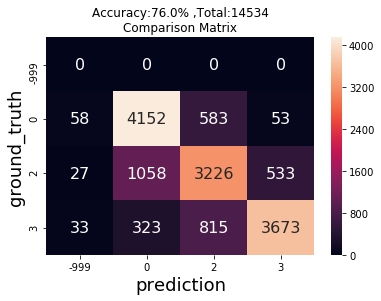

Class -999 Precision:0.0% Recall_rate:nan%
Class 0 Precision:75.0% Recall_rate:85.7%
Class 2 Precision:69.8% Recall_rate:66.6%
Class 3 Precision:86.2% Recall_rate:75.8%


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [24]:
balance = confusion_matrix_balance(combine_matrix_3_class.copy())
balance_0 = balance.copy()
balance_0[0,0]=0
plot_confusion_matrix(balance_0,raw_only_stage,columns_only_stage,'prediction','ground_truth')
get_precision_recallrate(balance_0,raw_only_stage)

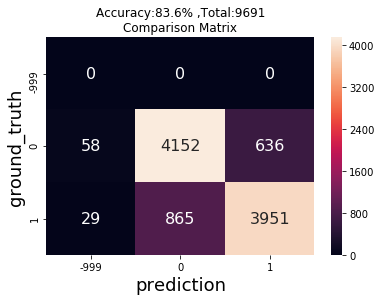

Class -999 Precision:0.0% Recall_rate:nan%
Class 0 Precision:82.8% Recall_rate:85.7%
Class 1 Precision:86.1% Recall_rate:81.5%


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [25]:
index_list  = [[0],[1],[2,3]]
max_column = 3
binary_combine_class = combine_class_in_matrix(binary.copy(),index_list,max_column)
#print(combine_matrix)
binary_balance_0 = confusion_matrix_balance(binary_combine_class.copy())
binary_balance_0[0,0]=0
raw_only_stage = ['-999','0','1']
columns_only_stage = ['-999','0','1']
plot_confusion_matrix(binary_balance_0,raw_only_stage,columns_only_stage,'prediction','ground_truth')
get_precision_recallrate(binary_balance_0,raw_only_stage)

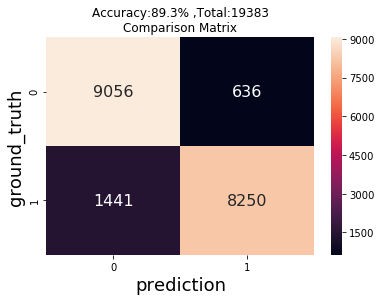

Class 0 Precision:86.3% Recall_rate:93.4%
Class 1 Precision:92.8% Recall_rate:85.1%


In [26]:
index_list  = [[0,1],[2,3]]
max_column = 3
combine_matrix = combine_class_in_matrix(balance,index_list,max_column)
#print(combine_matrix)

raw_only_stage = ['0','1']
columns_only_stage = ['0','1']

balance = confusion_matrix_balance(combine_matrix)
plot_confusion_matrix(balance,raw_only_stage,columns_only_stage,'prediction','ground_truth')
get_precision_recallrate(balance,raw_only_stage)

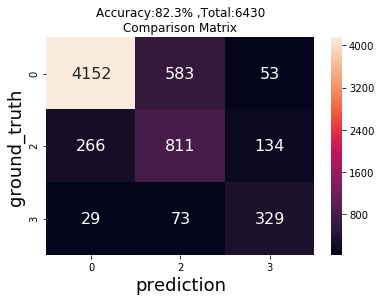

Class 0 Precision:93.4% Recall_rate:86.7%
Class 2 Precision:55.3% Recall_rate:67.0%
Class 3 Precision:63.8% Recall_rate:76.3%


In [27]:
index_list  = [[2,3],[4],[5]]
max_column = 5
combine_matrix = combine_class_in_matrix(array_5_classes,index_list,max_column)
#print(combine_matrix)

raw_only_stage = ['0','2','3']
columns_only_stage = ['0','2','3']
plot_confusion_matrix(combine_matrix,raw_only_stage,columns_only_stage,'prediction','ground_truth')
get_precision_recallrate(combine_matrix,raw_only_stage)

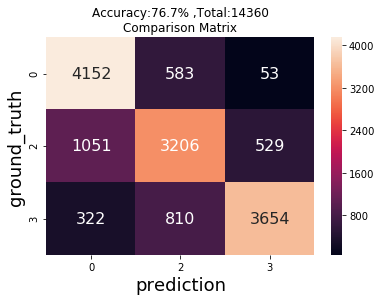

Class 0 Precision:75.1% Recall_rate:86.7%
Class 2 Precision:69.7% Recall_rate:67.0%
Class 3 Precision:86.3% Recall_rate:76.3%


In [28]:
index_list  = [[2,3],[4],[5]]
max_column = 5
combine_matrix = combine_class_in_matrix(array_5_classes,index_list,max_column)
#print(combine_matrix)

raw_only_stage = ['0','2','3']
columns_only_stage = ['0','2','3']
balance = confusion_matrix_balance(combine_matrix)
plot_confusion_matrix(balance,raw_only_stage,columns_only_stage,'prediction','ground_truth')
get_precision_recallrate(balance,raw_only_stage)

In [29]:
assert True == False , 'stop'

AssertionError: stop

# Using the four classes (combine 0,1) to confusin matrix

In [ ]:
def stage_(str_val):
    try:
        float_val = float(str_val)
    except:
        return -999
    if (float_val == -999) or (float_val == --99):
        return -999
    elif (float_val > -99 and float_val < 0) or float_val == 0:
        return 0
    elif float_val < 15:
        return 1
    elif float_val < 33:
        return 2
    else:
        return 3

# def stage_(str_val):
#     try:
#         float_val = float(str_val)
#     except:
#         return -999
#     if (float_val == -999) or (float_val == --99):
#         return -999
#     elif (float_val > -99 and float_val < 0) or float_val == 0:
#         return 0
#     elif float_val < 12:
#         return 11
#     elif float_val < 18:
#         return 12
#     elif float_val < 30:
#         return 22
#     elif float_val < 36:
#         return 23
#     else:
#         return 33
    
# def GT_new_stage(val):
#     if (val == 0):
#         return 0
#     elif (val == 1):
#         return 11
#     elif (val == 2):
#         return 22
#     elif (val == 3):
#         return 33
#     else:
#         return val

In [ ]:
Ground_truth_stage = Match_result_dropna['stage']
Ground_truth_stage_list = list(Ground_truth_stage)
PBL_predict_val = Match_result_dropna['PBL_value']
PBL_predict_val_list = list(PBL_predict_val)
print(len(Ground_truth_stage_list)==len(PBL_predict_stage_list))

In [ ]:
PBL_predict_stage_list = [stage_(val) for val in PBL_predict_val_list]
# Ground_truth_stage_list = [GT_new_stage(val) for val in Ground_truth_stage_list]
print(set(PBL_predict_stage_list))
print(set(Ground_truth_stage_list))

In [ ]:
Ground_truth_stage_list_clean = []
PBL_predict_stage_list_clean = []

count = 0

for G,P in zip(Ground_truth_stage_list,PBL_predict_stage_list):  
    if (G < 0 or P < 0):
        pass
    else:
        Ground_truth_stage_list_clean.append(G)
        PBL_predict_stage_list_clean.append(P)

In [ ]:
# PBL_predict_stage_list_clean.append(-999)
# PBL_predict_stage_list_clean.append(-999)
# PBL_predict_stage_list_clean.append(-999)

# Ground_truth_stage_list_clean.append(12)
# Ground_truth_stage_list_clean.append(23)
# Ground_truth_stage_list_clean.append(-999)

In [ ]:
print(set(PBL_predict_stage_list_clean))
print(set(Ground_truth_stage_list_clean))

In [ ]:
array_4  = confusion_matrix(Ground_truth_stage_list_clean, PBL_predict_stage_list_clean)
# print(array_4.shape)
raw_5 = ['-999','0','1','12','2','23','3']
columns_5 = ['-999','0','1','12','2','23','3']
plot_confusion_matrix(array_4,raw_5,columns_5,'prediction','ground_truth')
get_precision_recallrate(array_4,raw_5)

In [ ]:
array_4  = confusion_matrix(Ground_truth_stage_list_clean, PBL_predict_stage_list_clean)


index_list  = [[0,1],[2],[3]]
max_column = 3
combine_matrix = combine_class_in_matrix(array_4,index_list,max_column)

raw_only_stage = ['0','2','3']
columns_only_stage = ['0','2','3']
plot_confusion_matrix(combine_matrix,raw_only_stage,columns_only_stage,'prediction','ground_truth')
get_precision_recallrate(combine_matrix,raw_only_stage)

In [ ]:
array_4  = confusion_matrix(Ground_truth_stage_list_clean, PBL_predict_stage_list_clean)


index_list  = [[0,1],[2],[3]]
max_column = 3
combine_matrix = combine_class_in_matrix(array_4,index_list,max_column)

raw_only_stage = ['0','2','3']
columns_only_stage = ['0','2','3']
balance = confusion_matrix_balance(combine_matrix)
plot_confusion_matrix(balance,raw_only_stage,columns_only_stage,'prediction','ground_truth')
get_precision_recallrate(balance,raw_only_stage)

# Compare on value

In [30]:
def floval_(str_val):
    try:
        float_val = float(str_val)
    except:
        return -999
    if (float_val == -999) or (float_val == --99):
        return -999
    elif (float_val > -99 and float_val < 0) or float_val == 0:
        return 0
    else :
        return float_val

In [31]:
def stage_(str_val):
    int_val = int(str_val)
    if int_val == 0:
        return 0
    elif int_val < 15:
        return 1
    elif int_val < 33:
        return 2
    else:
        return 3

In [32]:
Ground_truth_stage = Match_result_dropna['stage']
Ground_truth_stage_list = list(Ground_truth_stage)
PBL_predict_val = Match_result_dropna['PBL_value']
PBL_predict_val_list = list(PBL_predict_val)
print(len(Ground_truth_stage_list)==len(PBL_predict_stage_list))

False


In [33]:
PBL_predict_floval_list = [floval_(val) for val in PBL_predict_val_list]


In [34]:
Ground_truth_stage_list_clean = []
PBL_predict_stage_list_clean = []

count = 0

for G,P in zip(Ground_truth_stage_list,PBL_predict_floval_list):  
    if (G < 0 or P < 0 or P > 100):
        pass
    else:
        Ground_truth_stage_list_clean.append(G)
        PBL_predict_stage_list_clean.append(P)

In [35]:
#print(set(PBL_predict_stage_list_clean))
#print(set(Ground_truth_stage_list_clean))

In [36]:
c0 = Ground_truth_stage_list_clean.count(0)
c1 = Ground_truth_stage_list_clean.count(1)
c2 = Ground_truth_stage_list_clean.count(2)
c3 = Ground_truth_stage_list_clean.count(3)
cs = c0+c1+c2+c3
print(round((c0*100/cs),3),'%')
print(round((c1*100/cs),3),'%')
print(round((c2*100/cs),3),'%')
print(round((c3*100/cs),3),'%')

20.123 %
51.801 %
20.491 %
7.585 %


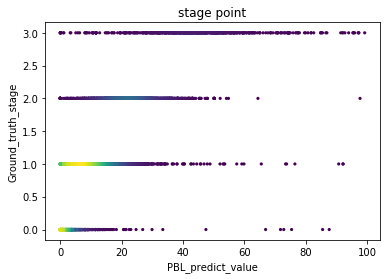

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate fake data
x = PBL_predict_stage_list_clean
y = Ground_truth_stage_list_clean

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=10, edgecolor='')
plt.title("stage point")
plt.xlabel("PBL_predict_value")
plt.ylabel("Ground_truth_stage")
plt.show()

In [38]:
#stage 0,1,2,3
x0,y0 = [],[]
x1,y1 = [],[]
x2,y2 = [],[]
x3,y3 = [],[]
for x,y in zip(PBL_predict_stage_list_clean,Ground_truth_stage_list_clean):
    if y == 0:
        x0.append(x)
        y0.append(y)
    elif y == 1:
        x1.append(x)
        y1.append(y)
    elif y == 2:
        x2.append(x)
        y2.append(y)
    elif y == 3:
        x3.append(x)
        y3.append(y)
x0count = x0.copy()
y0count = y0.copy()
x1count = x1.copy()
y1count = y1.copy()
x2count = x2.copy()
y2count = y2.copy()
x3count = x3.copy()
y3count = y3.copy()

x0.append(0)
y0.append(1)
x1.append(0)
y1.append(0)
x2.append(0)
y2.append(0)
x3.append(0)
y3.append(0)


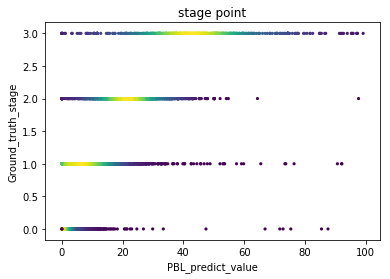

In [39]:
# Generate fake data

# Calculate the point density
xy0 = np.vstack([x0,y0])
z0 = gaussian_kde(xy0)(xy0)
xy1 = np.vstack([x1,y1])
z1 = gaussian_kde(xy1)(xy1)
xy2 = np.vstack([x2,y2])
z2 = gaussian_kde(xy2)(xy2)
xy3 = np.vstack([x3,y3])
z3 = gaussian_kde(xy3)(xy3)

fig, ax = plt.subplots()
ax.scatter(x0, y0, c=z0, s=10, edgecolor='')
ax.scatter(x1, y1, c=z1, s=10, edgecolor='')
ax.scatter(x2, y2, c=z2, s=10, edgecolor='')
ax.scatter(x3, y3, c=z3, s=10, edgecolor='')
plt.title("stage point")
plt.xlabel("PBL_predict_value")
plt.ylabel("Ground_truth_stage")
plt.show()

[181, 133, 64, 22, 19, 6, 1, 4, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
[269, 389, 428, 374, 306, 212, 118, 57, 34, 25, 8, 9, 4, 4, 3, 3, 1, 1, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0]
[4, 11, 29, 53, 62, 127, 128, 149, 151, 102, 56, 46, 24, 16, 16, 6, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[4, 2, 2, 7, 1, 5, 5, 11, 9, 12, 19, 20, 31, 35, 31, 26, 19, 24, 16, 10, 9, 6, 3, 7, 4, 3, 2, 3, 4, 0, 2, 1, 3, 1]


<Figure size 1080x576 with 0 Axes>

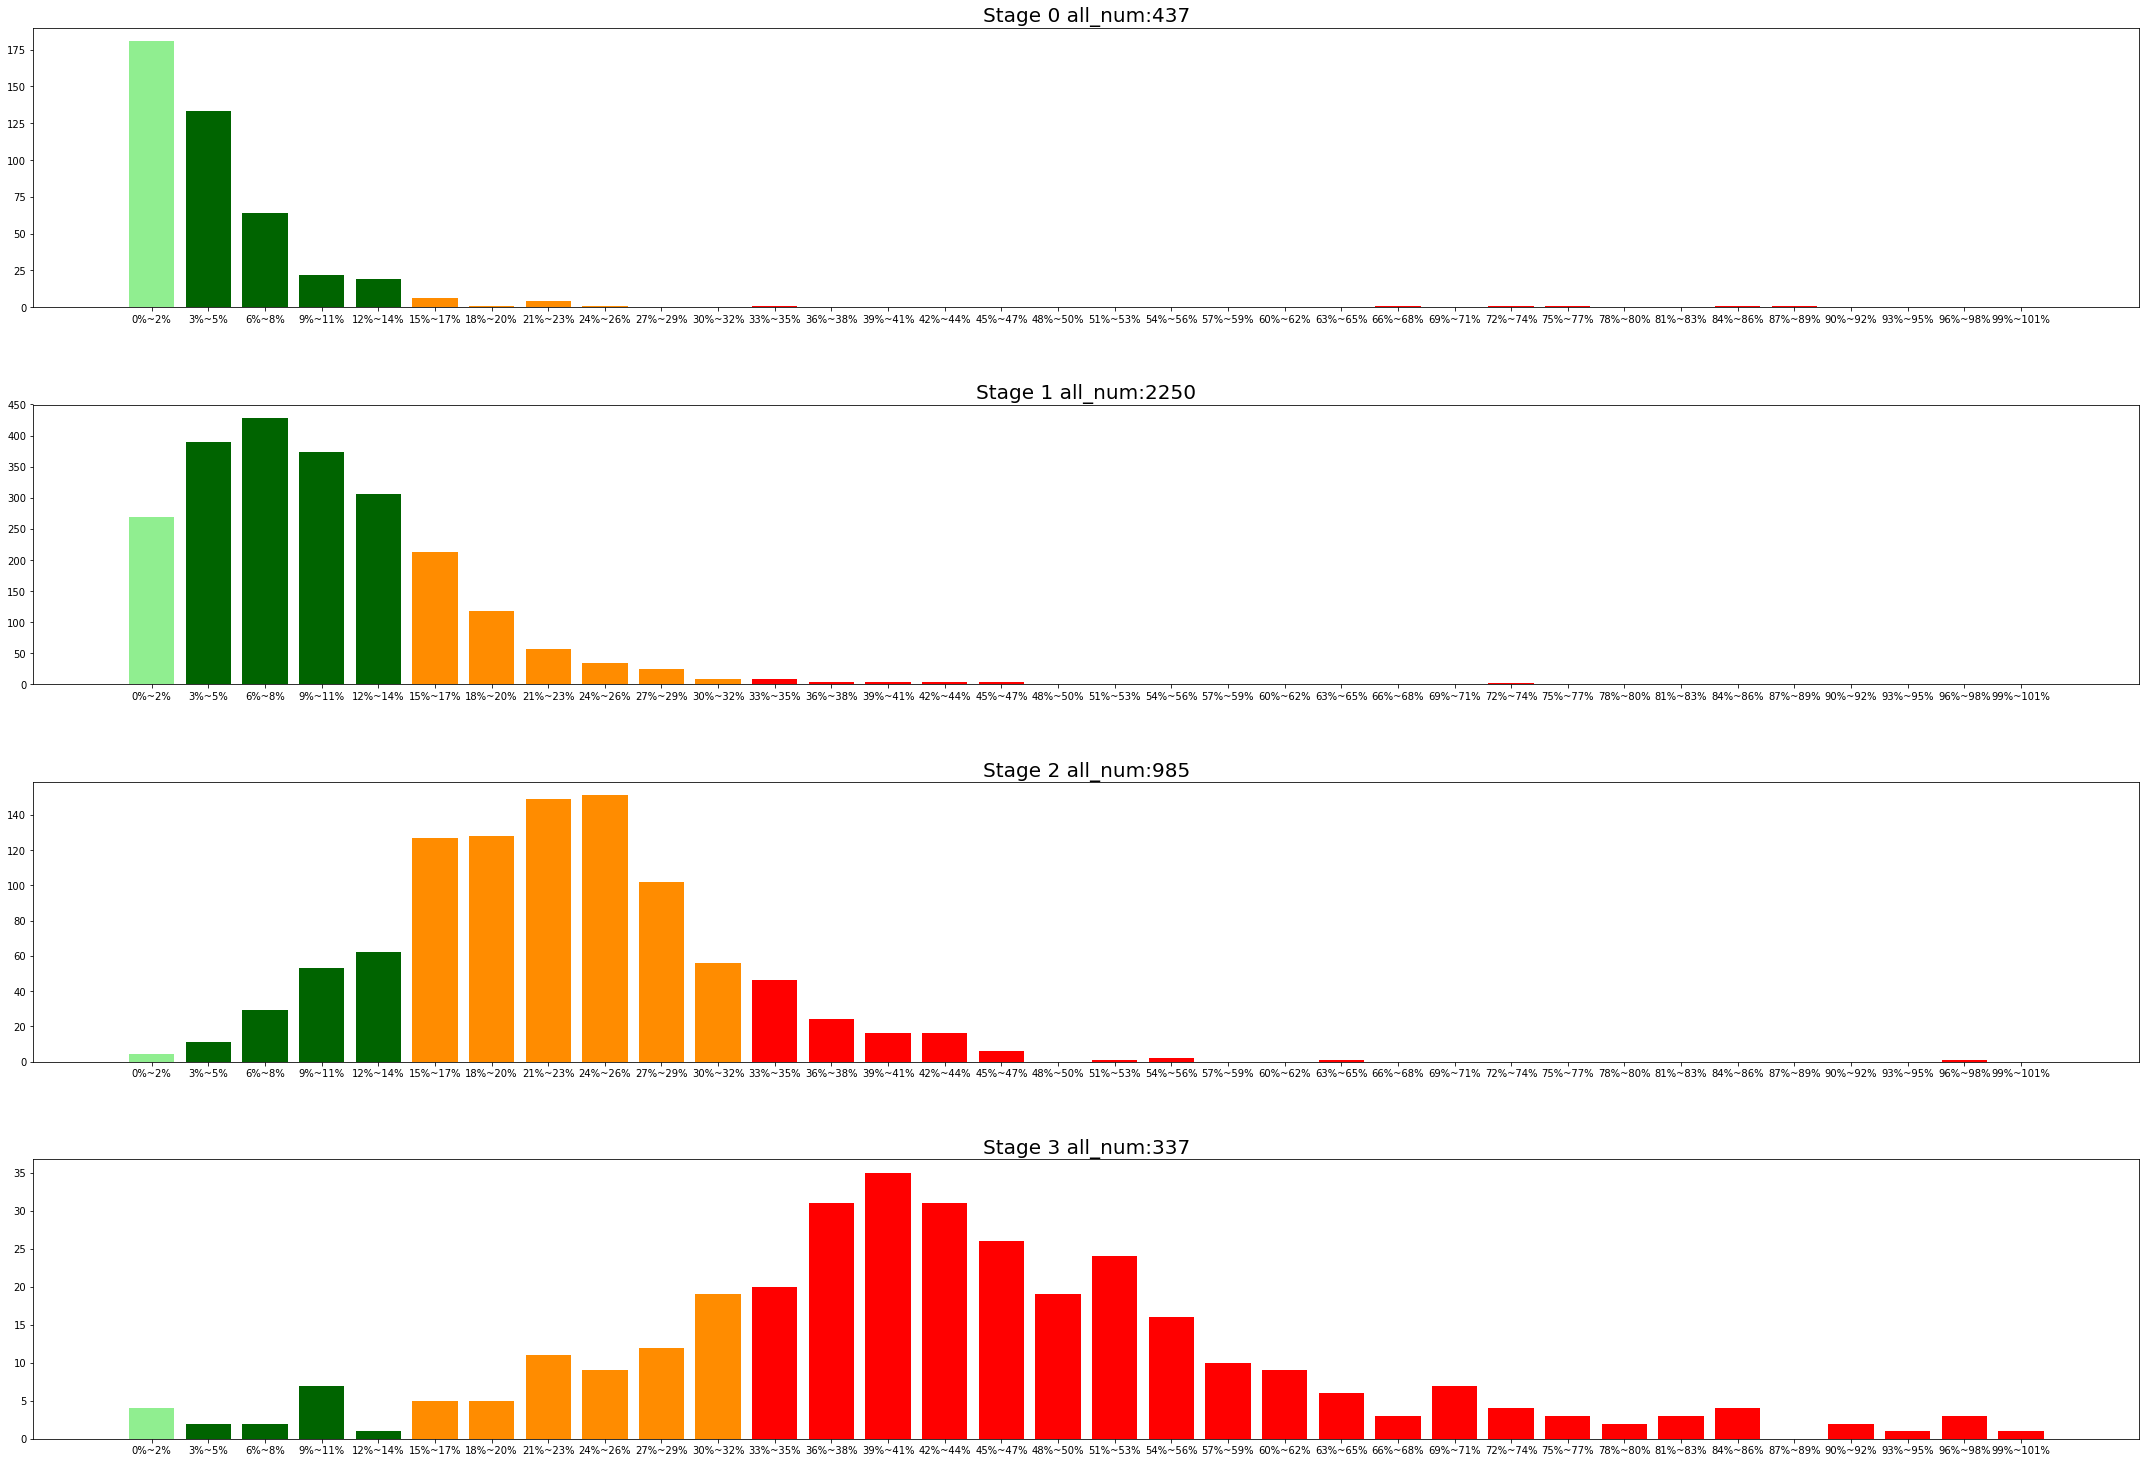

In [40]:
import matplotlib.pyplot as plt

def get_value_count(list_,min_,max_):
    count = 0
    for i in list_:
        if (i > min_ ) and (i <= max_):
            count+=1
    return count

dict_ = {0:'lightgreen',1:'darkgreen',2:'darkorange',3:'r',}
color = [dict_[stage_(i*3)] for i in range(34)]

x = ['{}%~{}%'.format(i*3,(i+1)*3-1) for i in range(34)]

y0count = [ get_value_count(x0count,i*3,(i+1)*3-1) for i in range(34)] 
y1count = [ get_value_count(x1count,i*3,(i+1)*3-1) for i in range(34)] 
y2count = [ get_value_count(x2count,i*3,(i+1)*3-1) for i in range(34)] 
y3count = [ get_value_count(x3count,i*3,(i+1)*3-1) for i in range(34)] 

fig = plt.figure(figsize=(15,8))
fig, ax = plt.subplots(4, 1)
ax[0].bar(x, y0count, color = color)
ax[1].bar(x, y1count, color = color)
ax[2].bar(x, y2count, color = color)
ax[3].bar(x, y3count, color = color)

ax[0].set_title("Stage 0 all_num:{}".format(sum(y0count)), fontsize=20)
ax[1].set_title("Stage 1 all_num:{}".format(sum(y1count)), fontsize=20)
ax[2].set_title("Stage 2 all_num:{}".format(sum(y2count)), fontsize=20)
ax[3].set_title("Stage 3 all_num:{}".format(sum(y3count)), fontsize=20)

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=5, 
                    top=5, 
                    wspace=8, 
                    hspace=0.35)

print(y0count)
print(y1count)
print(y2count)
print(y3count)

In [41]:
human_can_detect = Match_result_dropna['stage']
model_can_detect = Match_result_dropna['PBL_stage']
print(len(human_can_detect) == len(model_can_detect))
print(len(human_can_detect))
print(len(model_can_detect))
human_can_detect_list = list(human_can_detect) 
model_can_detect_list = list(model_can_detect) 
print(set(human_can_detect_list))
print(set(model_can_detect_list))

True
9434
9434
{0.0, 1.0, 2.0, 3.0}
{'No_match', '3', '1', '-999', '2', '0'}


In [42]:
human_can_detect_ = []
model_can_detect_ = []

print(len(human_can_detect))
print(len(model_can_detect))

for h,m in zip(human_can_detect,model_can_detect):
    if h == -999 or h ==-99:
        human_can_detect_.append(0)
    else:
        human_can_detect_.append(1)

    if str(m) == 'No_match' or str(m) == '-999':
        model_can_detect_.append(0)
    else:
        model_can_detect_.append(1)

9434
9434


In [43]:
print(len(human_can_detect_),len(model_can_detect_))

9434 9434


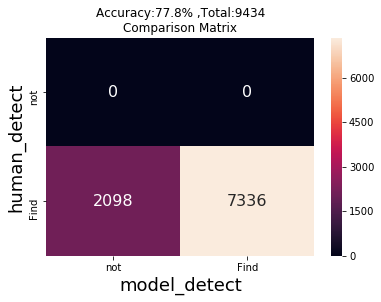

Missing rate 22.23871104515582 %


In [44]:
from sklearn.metrics import confusion_matrix

array = confusion_matrix(human_can_detect_, model_can_detect_)

index = ['not','Find']
columns = ['not','Find']

plot_confusion_matrix(array,index,columns,x_label='model_detect',y_label='human_detect')

print('Missing rate',(array[1][0]/sum(array[1]))*100,'%')